In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName('TemperatureAnalysis').getOrCreate()

# Load the dataset
df = spark.read.csv('GlobalLandTemperaturesByCountry.csv', header=True, inferSchema=True)

# Show the first few rows of the dataset
df.show()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 03:55:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+-------------------+-----------------------------+-------+
|        dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+-------------------+-----------------------------+-------+
|1743-11-01| 4.3839999999999995|                        2.294|  Åland|
|1743-12-01|               null|                         null|  Åland|
|1744-01-01|               null|                         null|  Åland|
|1744-02-01|               null|                         null|  Åland|
|1744-03-01|               null|                         null|  Åland|
|1744-04-01|               1.53|                         4.68|  Åland|
|1744-05-01|  6.702000000000001|                        1.789|  Åland|
|1744-06-01| 11.609000000000002|                        1.577|  Åland|
|1744-07-01|             15.342|                         1.41|  Åland|
|1744-08-01|               null|                         null|  Åland|
|1744-09-01|             11.702|                        1.517|  Åland|
|1744-

+-----+------------------+-----------------------------+-------+
|   dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+-----+------------------+-----------------------------+-------+
|false|             false|                        false|  false|
|false|              true|                         true|  false|
|false|              true|                         true|  false|
|false|              true|                         true|  false|
|false|              true|                         true|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|              true|                         true|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false

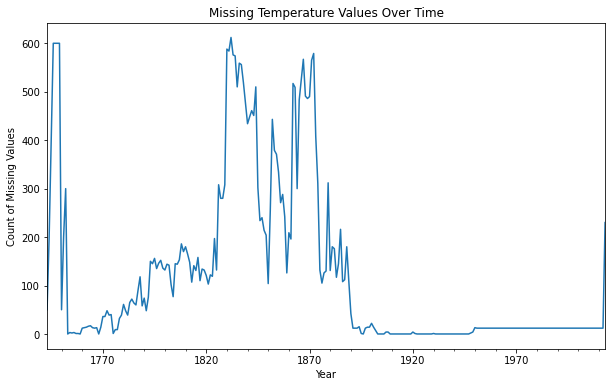

24/05/23 03:56:51 WARN TaskSetManager: Stage 6 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


+-----+------------------+-----------------------------+-------+
|   dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+-----+------------------+-----------------------------+-------+
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false|                        false|  false|
|false|             false

In [3]:
#Data Preprocessing
# Convert the 'dt' column to datetime
df = df.withColumn('dt', col('dt').cast('timestamp'))

# Check for null values
df.select([col(c).isNull().alias(c) for c in df.columns]).show()

# Plotting missing values over time (Visualize in Pandas after converting to Pandas DataFrame)
pandas_df = df.select("dt", "AverageTemperature").toPandas()
pandas_df['dt'] = pd.to_datetime(pandas_df['dt'])
missing_values = pandas_df.set_index('dt')['AverageTemperature'].isnull().resample('Y').sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
missing_values.plot(ax=ax)
ax.set_title('Missing Temperature Values Over Time')
ax.set_ylabel('Count of Missing Values')
ax.set_xlabel('Year')
plt.show()

# Filter data for years >= 1850
filtered_df = df.filter(year('dt') >= 1870)

# Handle missing values using interpolation (Note: PySpark does not support direct interpolation, so convert to Pandas)
pandas_filtered_df = filtered_df.toPandas()
pandas_filtered_df['AverageTemperature'] = pandas_filtered_df['AverageTemperature'].interpolate(method='linear')
pandas_filtered_df['AverageTemperatureUncertainty'] = pandas_filtered_df['AverageTemperatureUncertainty'].interpolate(method='linear')

# Convert back to Spark DataFrame
filtered_df = spark.createDataFrame(pandas_filtered_df)

# Verify missing values are handled
filtered_df.select([col(c).isNull().alias(c) for c in filtered_df.columns]).show()


24/05/23 03:56:52 WARN TaskSetManager: Stage 7 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.
24/05/23 03:56:54 WARN TaskSetManager: Stage 10 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


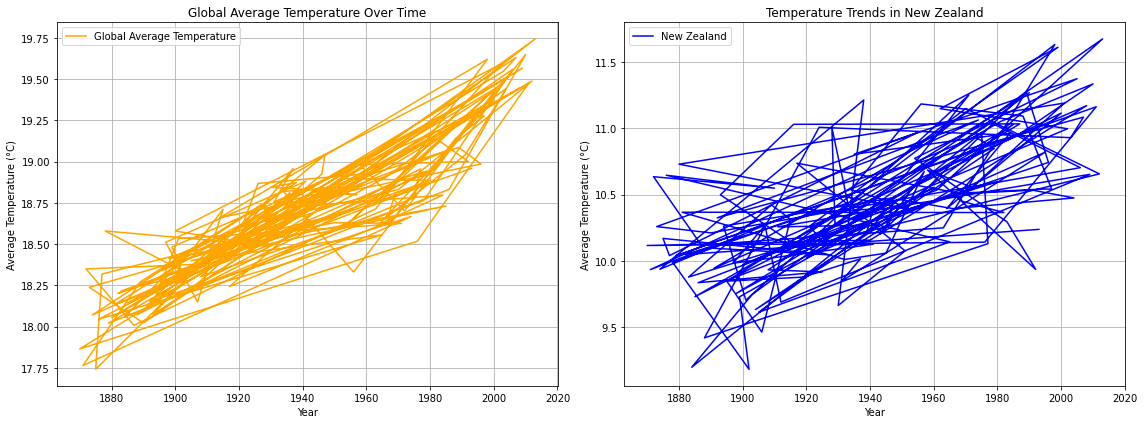

In [4]:
#EDA and Visualization 
# Group by year and calculate the global average temperature
global_avg_temp = filtered_df.groupBy(year('dt').alias('Year')).avg('AverageTemperature')

# Filter data for New Zealand and calculate yearly averages
nz_avg_temp = filtered_df.filter(col('Country') == 'New Zealand').groupBy(year('dt').alias('Year')).avg('AverageTemperature')

# Convert to Pandas for plotting
global_avg_temp_pd = global_avg_temp.toPandas()
nz_avg_temp_pd = nz_avg_temp.toPandas()

# Plotting global and New Zealand temperature trends
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(global_avg_temp_pd['Year'], global_avg_temp_pd['avg(AverageTemperature)'], label='Global Average Temperature', color='orange')
ax[0].set_title('Global Average Temperature Over Time')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Average Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(nz_avg_temp_pd['Year'], nz_avg_temp_pd['avg(AverageTemperature)'], label='New Zealand', color='blue')
ax[1].set_title('Temperature Trends in New Zealand')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Average Temperature (°C)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


24/05/23 04:14:24 WARN TaskSetManager: Stage 73 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.
24/05/23 04:14:25 WARN TaskSetManager: Stage 76 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


+----+------------------+----------------------------------+--------+
|Year|             label|avg(AverageTemperatureUncertainty)|features|
+----+------------------+----------------------------------+--------+
|1959|18.864975673066926|                0.3838144718792865|[1959.0]|
|1896|18.341112044817915|                0.7555119047619048|[1896.0]|
|1990|19.345458774314416|                0.3593148148148146|[1990.0]|
|1903| 18.43477083333333|                0.7248583333333338|[1903.0]|
|1884|18.056577052731082|                0.9659561948298615|[1884.0]|
|1975| 18.78160870519006|                0.3599595336076816|[1975.0]|
|1977|18.955841640789806|               0.33099211248285315|[1977.0]|
|1888|  18.0713495559568|                0.9100154548671241|[1888.0]|
|1924|18.621859027777795|                0.5534086805555557|[1924.0]|
|2003| 19.54782453609687|               0.37877434842249635|[2003.0]|
|2007|19.631494453935627|               0.33988957475994497|[2007.0]|
|1892| 18.1526791584

24/05/23 04:14:26 WARN TaskSetManager: Stage 77 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.
24/05/23 04:14:27 WARN Instrumentation: [59b98062] regParam is zero, which might cause numerical instability and overfitting.
24/05/23 04:14:27 WARN TaskSetManager: Stage 80 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.
24/05/23 04:14:28 WARN TaskSetManager: Stage 83 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


Coefficient: 0.009396486627958103
Intercept: 0.4619793204509091
+----+------------------+----------------------------------+--------+------------------+
|Year|             label|avg(AverageTemperatureUncertainty)|features|        prediction|
+----+------------------+----------------------------------+--------+------------------+
|1872|18.349258722454774|                 1.312519669027076|[1872.0]|18.052202287988475|
|1881|18.133924945644345|                0.9705230585606344|[1881.0]|  18.1367706676401|
|1886|18.120893048647744|                0.9374242015032306|[1886.0]| 18.18375310077989|
|1887|18.007207635902336|                0.9058086140137813|[1887.0]| 18.19314958740785|
|1896|18.341112044817915|                0.7555119047619048|[1896.0]| 18.27771796705947|
|1901| 18.53280956500249|                  0.77284114282968|[1901.0]|18.324700400199262|
|1911|18.408202430555562|                0.6089822916666667|[1911.0]|18.418665266478843|
|1912|18.464740972222206|                0.629

24/05/23 04:14:29 WARN TaskSetManager: Stage 86 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.
24/05/23 04:14:30 WARN TaskSetManager: Stage 89 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


R2: 0.7450384568349269


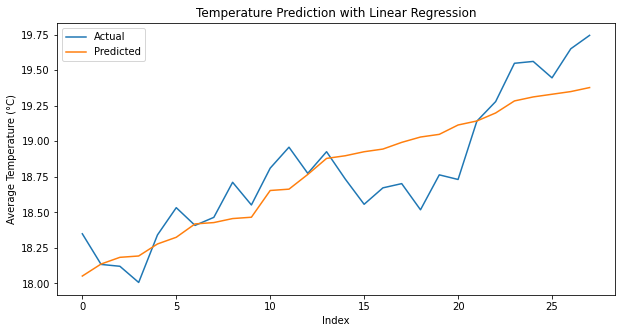

In [14]:
#Regression
# Preparing the data for regression
# Preparing the data for regression
from pyspark.ml.evaluation import RegressionEvaluator
# Preparing the data for regression
yearly_data = filtered_df.withColumn('Year', year('dt'))
yearly_avg_temp = yearly_data.groupBy('Year').agg({'AverageTemperature': 'mean', 'AverageTemperatureUncertainty': 'mean'})

# Assemble features
assembler = VectorAssembler(inputCols=['Year'], outputCol='features')
yearly_avg_temp = assembler.transform(yearly_avg_temp)
yearly_avg_temp = yearly_avg_temp.withColumnRenamed('avg(AverageTemperature)', 'label')

# Verify the "features" column exists
yearly_avg_temp.show()

# Split the data into training and testing sets
train_data, test_data = yearly_avg_temp.randomSplit([0.8, 0.2], seed=20)

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

# Print the coefficients and intercept
print(f"Coefficient: {lr_model.coefficients[0]}")
print(f"Intercept: {lr_model.intercept}")

# Make predictions
predictions = lr_model.transform(test_data)
predictions.show()

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2: {r2}")

# Convert predictions to Pandas for visualization
predictions_pd = predictions.select("prediction", "label").toPandas()

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(predictions_pd['label'].values, label='Actual')
plt.plot(predictions_pd['prediction'].values, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Average Temperature (°C)')
plt.title('Temperature Prediction with Linear Regression')
plt.legend()
plt.show()


24/05/23 04:14:49 WARN TaskSetManager: Stage 92 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


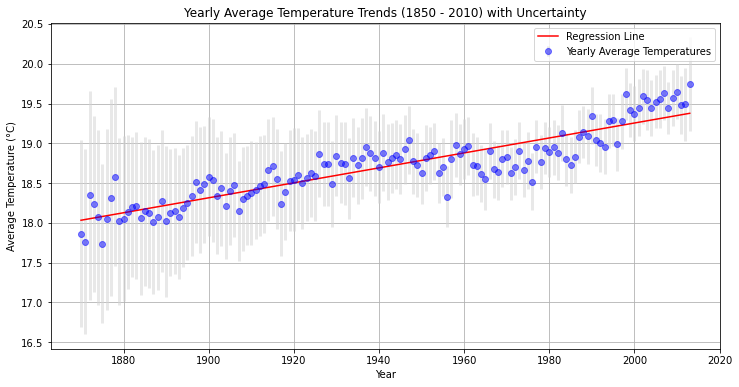

In [15]:
import numpy as np

# Convert the yearly_avg_temp DataFrame to Pandas for plotting
yearly_avg_temp_pd = yearly_avg_temp.toPandas()

# Prepare the data for regression plot
X = yearly_avg_temp_pd['Year'].values.reshape(-1, 1)
Y = yearly_avg_temp_pd['label'].values

# Generate predictions for the plot using a range of years
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_plot_spark = spark.createDataFrame(pd.DataFrame({'Year': X_plot.flatten()}))

# Apply the assembler to create the features column
X_plot_spark = assembler.transform(X_plot_spark)

# Generate predictions
Y_plot = lr_model.transform(X_plot_spark).select('prediction').collect()
Y_plot = [row['prediction'] for row in Y_plot]

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(X.flatten(), Y, yerr=yearly_avg_temp_pd['avg(AverageTemperatureUncertainty)'].values, fmt='o', color='blue',
             label='Yearly Average Temperatures', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0)
plt.plot(X_plot, Y_plot, color='red', label='Regression Line')
plt.title('Yearly Average Temperature Trends (1850 - 2010) with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Calculate statistical measures for global and NZ average temperatures
print(global_avg_temp_pd.describe())
print(nz_avg_temp_pd.describe())

# Calculate correlation between AverageTemperature and AverageTemperatureUncertainty
correlation = filtered_df.stat.corr('AverageTemperature', 'AverageTemperatureUncertainty')
print(f"Correlation between AverageTemperature and AverageTemperatureUncertainty: {correlation}")


              Year  avg(AverageTemperature)
count   144.000000               144.000000
mean   1941.500000                18.707282
std      41.713307                 0.434220
min    1870.000000                17.740900
25%    1905.750000                18.406029
50%    1941.500000                18.718330
75%    1977.250000                18.924862
max    2013.000000                19.744139
              Year  avg(AverageTemperature)
count   144.000000               144.000000
mean   1941.500000                10.430440
std      41.713307                 0.509053
min    1870.000000                 9.182833
25%    1905.750000                10.056396
50%    1941.500000                10.390042
75%    1977.250000                10.781604
max    2013.000000                11.675167


24/05/23 03:58:53 WARN TaskSetManager: Stage 45 contains a task of very large size (8572 KiB). The maximum recommended task size is 1000 KiB.


Correlation between AverageTemperature and AverageTemperatureUncertainty: -0.10417550672039086


In [9]:
print(yearly_avg_temp_pd)

     Year      label  avg(AverageTemperatureUncertainty)  features
0    1959  18.864976                            0.383814  [1959.0]
1    1896  18.341112                            0.755512  [1896.0]
2    1990  19.345459                            0.359315  [1990.0]
3    1903  18.434771                            0.724858  [1903.0]
4    1884  18.056577                            0.965956  [1884.0]
..    ...        ...                                 ...       ...
139  1929  18.485819                            0.541373  [1929.0]
140  1928  18.738459                            0.530767  [1928.0]
141  1933  18.558324                            0.514121  [1933.0]
142  1882  18.201539                            0.878361  [1882.0]
143  1993  18.959199                            0.341130  [1993.0]

[144 rows x 4 columns]


In [10]:
Y


array([18.86497567, 18.34111204, 19.34545877, 18.43477083, 18.05657705,
       18.78160871, 18.95584164, 18.07134956, 18.62185903, 19.54782454,
       19.63149445, 18.15267916, 18.66718994, 17.76382537, 18.27094968,
       18.73918194, 17.74089951, 18.31856225, 18.69903278, 18.23766487,
       18.02200965, 19.56085004, 18.76356973, 18.30225347, 18.58891319,
       18.12089305, 18.96228714, 19.74413872, 18.76261076, 18.81152917,
       18.85743472, 18.48265196, 18.34005427, 18.57950206, 18.50415312,
       18.84779294, 18.81882361, 18.33053419, 19.14094223, 19.27614905,
       19.27845928, 18.64359676, 18.24255417, 18.81766807, 18.84468316,
       18.87344514, 18.07040425, 18.9083624 , 18.94253411, 18.211075  ,
       18.92441424, 19.04098785, 18.19113828, 18.53280957, 18.62509208,
       18.6301446 , 18.49148958, 18.7284899 , 18.9036368 , 19.44493192,
       19.0400713 , 18.67216976, 18.80830016, 18.88442998, 18.13392495,
       18.74608264, 18.80656736, 18.80029795, 18.8170434 , 19.08